In [90]:
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set()

In [299]:
#@title KMeans
def next_centroid(cluster):
    return tuple(np.mean(cluster, axis=0))


def distance(centroids, sample):
    return np.linalg.norm(np.subtract(centroids, sample), axis=1)


class KMeansModel:

    def __init__(self):
        self.clusters = None
        self.centroids = None
        self.trained = False

    def _update_clusters(self, samples, max_iter):
        reassignment = True
        j = 0
        while reassignment is True and j < max_iter:
            reassignment = False

            old_clusters = self.clusters
            new_clusters = [[] for _ in range(len(self.clusters))]

            for sample in samples:
                closest_centroid_idx = self._closest_centroid(sample)
                new_clusters[closest_centroid_idx].append(sample)

            self.clusters = np.array(new_clusters, dtype="object")

            for i in range(len(new_clusters)):
                if not np.isin(new_clusters[i], old_clusters[i]).all():
                    reassignment = True

            for i in range(len(self.centroids)):
                self.centroids[i] = next_centroid(self.clusters[i])

            j += 1

    def _closest_centroid(self, sample):
        return distance(self.centroids, sample).argmin()

    def train(self, samples, n_clusters, max_iter, initial_centroids=None):
        if len(samples) == 0:
            raise ValueError("La lista de muestras no debe estar vacía")

        if initial_centroids is not None:
            self.centroids = initial_centroids
        else:
            self.centroids = samples[np.random.choice(np.arange(len(samples)), n_clusters, replace=False)]

        if self.clusters is None:
            self.clusters = [[] for _ in range(n_clusters)]

        self._update_clusters(samples, max_iter)

        self.trained = True

        return [tuple(centroid) for centroid in self.centroids]

    def process(self, sample):
        if len(sample) == 0:
            raise ValueError("El argumento no debe estar vacío")

        if not self.trained:
            raise ValueError("Primero hay que entrenar el modelo")

        return self._closest_centroid(sample)

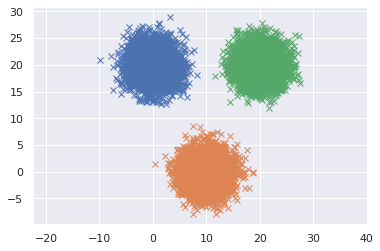

In [310]:
clusters = [[0,20], [10,0], [20,20]]
cov = [[5, 0], [0, 5]]

dist = []

for cluster in clusters:
  dist.append(np.random.multivariate_normal(cluster, cov, 5000))
  x, y = dist[-1].T
  # print(dist[-1])
  plt.plot(x, y, 'x')

samples = np.vstack(dist)

plt.axis('equal')
plt.show()

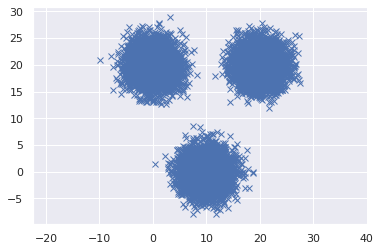

In [311]:
np.random.shuffle(samples)

plt.plot(samples[:,0], samples[:,1], 'x')

plt.axis('equal')
plt.show()

In [312]:
model = KMeansModel()
centroids = model.train(samples, 3, 200)
clusters = model.clusters

In [313]:
print(centroids)

[(9.956566658878703, 0.010284958101218874), (-0.023608792074403903, 19.959912696008523), (19.9778341145213, 19.959312802515818)]


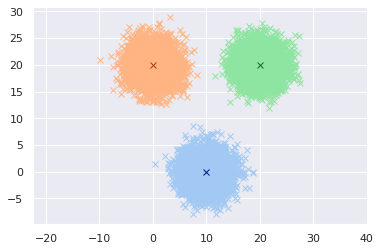

In [314]:
colors = sns.color_palette("pastel", 3)
centroid_colors = sns.color_palette("dark", 3)

for i, cluster in enumerate(clusters):
  plt.plot(cluster[:,0], cluster[:,1], 'x', color=colors[i])
  plt.plot(centroids[i][0], centroids[i][1], 'x', color=centroid_colors[i])

plt.axis('equal')
plt.show()

# Parte 2: Síntesis de muestras utilizando Autoencoders.

In [315]:
import numpy as np
import tensorflow as tf
import os
from IPython.display import clear_output

if not os.path.isfile("fashion_mnist_encoded.npy") or not os.path.isfile("autoencoder.h5"):
  !wget -O fashion_mnist_encoded.npy https://github.com/ManuSanchez02/CURSO-LEARNING1/blob/tareas_subidas/datasets/fashion_mnist_encoded.npy?raw=true
  !wget -O autoencoder.h5 https://github.com/ManuSanchez02/CURSO-LEARNING1/blob/tareas_subidas/modelos/autoencoder.h5?raw=true
  clear_output()
  print("Data successfully downloaded!")
else:
  print("Data already downloaded!")

fashion_mnist_encoded = np.load("fashion_mnist_encoded.npy")
(train_images, _), _ = tf.keras.datasets.fashion_mnist.load_data()

Data already downloaded!


In [281]:
#@title Funciones auxiliares
def show_images(images, labels=None, image_count=25, random=True):
  plt.figure(figsize=(10,10))
  cant_subplot = np.sqrt(image_count)
  cant_subplot_int = int(cant_subplot)

  if(cant_subplot_int != cant_subplot):
    print("image_count no es un numero con raiz entera, se va a recortar el numero de imagenes") 

  for i in range(image_count):
    plt.subplot(cant_subplot,cant_subplot,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img_index = i
    if random:
      img_index = np.random.randint(0, images.shape[0])
    plt.imshow(images[img_index], cmap="gray_r")
    if labels is not None:
      plt.xlabel(labels[img_index])


def desnormalizar(dataset):
  return (dataset + train_images.mean()) * train_images.std()

In [318]:
KMeans = KMeansModel()
centroids = KMeans.train(fashion_mnist_encoded, n_clusters=10, max_iter=10000)
clusters = KMeans.clusters


In [319]:
def generate_images_of_cluster(clusters, cluster_number, number_of_images):
  media = np.mean(clusters[cluster_number], axis=0)
  covarianza = np.cov(clusters[cluster_number], rowvar=0)
  return np.random.multivariate_normal(media, covarianza, number_of_images)

In [320]:
generate_images_of_cluster(clusters, 0, 50).shape

(50, 128)

In [321]:
autoencoder = tf.keras.models.load_model('autoencoder.h5')
autoencoder.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_12 (Flatten)        (None, 784)               0         
                                                                 
 dense_23 (Dense)            (None, 128)               100480    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_24 (Dense)            (None, 784)               101136    
                                                                 
 reshape_12 (Reshape)        (None, 28, 28)            0         
                                                                 
Total params: 201,616
Trainable params: 201,616
Non-trainable params: 0
_________________________________________________________________


In [322]:
def show_images_of_cluster(cluster_number):
  decoder = tf.keras.Model(inputs=autoencoder.get_layer("dense_24").input,
                        outputs=autoencoder.get_layer("reshape_12").output)

  imagenes_generadas = generate_images_of_cluster(clusters, cluster_number, 100)
  imagenes_decodificadas = np.array(decoder(imagenes_generadas))
  imagenes_decodificadas_desnormalizadas = desnormalizar(imagenes_decodificadas)

  show_images(imagenes_decodificadas_desnormalizadas)

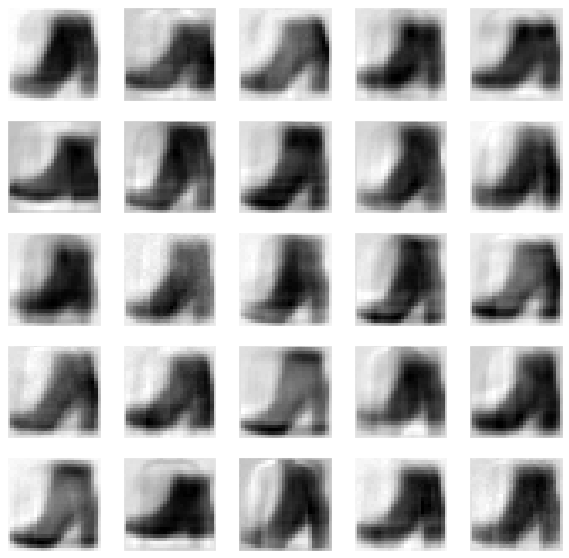

In [324]:
show_images_of_cluster(3)